# Prototipo GNN: Búsqueda de Camino Más Corto

### Librerías
El prototipo GNN usa las siguientes librerías:
1. `graph_nets` es la librería fundametal que implementa las funciones de GNN.
2. `matplotlib` es una librería para graficar los resultados.
3. `numpy` es una librería para manejo de arreglos multidimensionales.
4. `tensorflow` es una librería para machine learning con foco en deep learning.
5. `networkx` es una librería para manipuar grafos (usamos `geographical_threshold_graph` y `minimum_spanning_tree`).
6. `scipy` es una librería de la que usamos el módulo `spatial` para cálculos en espacios geométricos.

Se importan también `collections`, `itertools`, y `time` para la gestión de colecciones, iterables y variables de tiempo.

Finalmente, se establece una semilla (`SEED`) para la generación aleatoria de los grafos. La misma se asigna a los *handles* de TensorFlow y NumPy.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pdb

import collections
import time
import pandas as pd

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

import sys
from py_cgr_lib.py_cgr_lib import Contact
from py_cgr_lib.py_cgr_lib import cgr_dijkstra
from py_cgr_lib.py_cgr_lib import cp_load_from_list

# Inicializacion del generador de numeros aleatorios
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)
rand = np.random.RandomState(seed=SEED)

# Desactivo la representacion cientifica de numpy
np.set_printoptions(suppress=True)

### Funciones


In [2]:
def set_diff(seq0, seq1):
  ''' Devuelve los valores presentes en seq0 pero no en seq1.
  
  Parameters:
    seq0 <iterable>
    seq1 <iterable>
  
  Returns:
    <list>: Lista con los valores presentes en seq0 pero no en seq1
  '''

  return list(set(seq0) - set(seq1))


def to_one_hot(indice, max_value, axis=-1):
  ''' Returns a vector of length "max_value", with a "1" at the position indicated by "index".
  
    parameters:
      index <int>: input value to encode in one_hot
      max_value <int>: maximum number of values to encode (2 for true or false)
      axis <int, optional, default=-1>
  
    returns:
      one_hot <numpy.ndarray>: Encoding one hot
  '''

  one_hot = np.eye(max_value)[indice]
  if axis not in (-1, one_hot.ndim):
    one_hot = np.moveaxis(one_hot, -1, axis)
  return one_hot


def get_node_attr_dict(graph, attr):
  ''' Devuelve un diccionario de la forma "nodo:atributo" dado un grafo y un atributo en especifico.
  
  Parameters:
    graph <networkx.Multidigraph>: Grafo de entrada 
    attr <str>: atributo de interes
  
  Returns:
    <dict>: diccionario de salida con la forma {nodo1:atributo, nodo2:atributo, ...}
  '''

  return {k: v[attr] for k, v in graph.nodes.items()}


def load_contactplan(path_contactplan):
  ''' Carga el plan de contactos en np.array desde un archivo
  
  Parameters:
    path_contactplan <str>: Ruta al archivo del plan de contactos
  
  Returns:
    <numpy.ndarray>: np.array con el listado de contactos, formato: "[start, end, frm, to, rate, owlt]"
  
  Notes:
    Se debe procurar que la lista "contact" este en el mismo orden que la lista "range"
  '''

  contact_plan = []
  i_aux = 0
  with open(path_contactplan, 'r') as file:
    for contact in file.readlines():
      if contact[0] == '#':
        continue
      if contact.startswith('a contact'):
        fields  = contact.split(' ')[2:]  # ignore "a contact"
        start, end, frm, to, rate = map(float, fields)
        owlt = 0.1
        contact_plan.append([int(start), int(end), int(frm-1), int(to-1), int(rate), owlt])
      if contact.startswith('a range'):
        fields  = contact.split(' ')[2:]  # ignore "a range"
        start, end, frm, to, owlt = map(float, fields)
        contact_plan[i_aux][5] = owlt
        i_aux += 1
  return np.array(contact_plan)


def generate_graph(rand, contact_plan, t_window, t_inicial=None, node_A=None, node_B=None):
  ''' Genera un grafo apartir de un periodo especifico del contact plan [t_inicial, t_final=t_inicial + t_window].
  
  Parameters:
    rand <rand obj>: Maquina generadora de numeros aleatorios
    contact_plan <numpy.ndarray>: Listado de contactos
    t_window <int>: Longitud en segundos de la ventana considerada
    t_inicial <int, optional, default=None>: Tiempo inicial, si es igual a None se toma un tiempo aleatorio
    node_A <int, optional, default=None>: Nodo de origen, en caso de ser None se selecciona aleatoriamente
    node_B <int, optional, default=None>: Nodo de destino, en caso de ser None se selecciona aleatoriamente
  
  Returns:
    graph_from_cp <networkx.Multidigraph>: Grafo generado apartir del sub contact plan
    sub_contact_plan <numpy.ndarray>: Sub contact plan utilzado
  '''

  # Determino los limites de la ventana temporal
  t_inicial_max = contact_plan[:,1].max() - t_window
  if (t_inicial==None):
    t_inicial = rand.randint(t_inicial_max)
  else:
    if (t_inicial > t_inicial_max):
      raise ValueError("t_inicial inconsistent with t_window")
  t_final = t_inicial + t_window
  
  # Creo un sub contact plan
  sub_contact_plan = contact_plan[(contact_plan[:,1] > t_inicial) & (contact_plan[:,0] < t_final)]

  # Normalizo los tiempos, t=0 equivale a t_inicial
  sub_contact_plan[:,0]-=t_inicial
  sub_contact_plan[:,1]-=t_inicial
  sub_contact_plan[sub_contact_plan[:,0]<0, 0] = 0
  sub_contact_plan[sub_contact_plan[:,1]>t_window, 1] = t_window

  # Cargo todos los nodos al grafo
  ListOfNodes = np.unique(sub_contact_plan[:,2:4]).astype(int)
  graph = nx.MultiDiGraph()
  graph.add_nodes_from(ListOfNodes, frm=False, to=False)

  # Cargo todos los edge al grafo
  for i in sub_contact_plan:
    graph.add_edge(int(i[2]), int(i[3]),key=i[0], start=i[0], end=i[1], rate=i[4], owlt=i[5])

  # Cargo atributos globales
  graph.graph['t_inicial'] = t_inicial

  # Selecciono los nodos de inicio y de fin
  if node_A==None:
    node_frm = rand.choice(ListOfNodes[ListOfNodes!=node_B])
  else:
    if node_A in ListOfNodes:
      node_frm = node_A
    else:
      raise ValueError("node A, is not found in the list of valid nodes")
  
  if node_B==None:
    node_to = rand.choice(ListOfNodes[ListOfNodes!=node_frm])
  else:
    if node_B in ListOfNodes:
      node_to = node_B
    else:
      raise ValueError("node B, is not found in the list of valid nodes")
  
  if node_frm==node_to:
    raise ValueError("The destination node cannot be the same as the source node")

  # Marco los atributos "frm", "to" de los nodos
  graph.add_node(node_frm, frm=True)
  graph.add_node(node_to, to=True)

  return graph, sub_contact_plan


def add_cgr_path(rand, graph, sub_contact_plan):
  ''' Calcula la mejor ruta entre un nodo A y otro nodo B usando el algoritmo de CGR
  
  Parameters:
    rand  <rand obj>: Maquina generadora de numeros aleatorios
    graph <networkx.MultiDiGraph>: Grafo de entrada con los nodos A y B etiquetados como frm y to
    sub_contact_plan <numpy.ndarray>: Sub contact plan utilizado para generar el grafo
  
  Returns:
    labeled_graph <networkx.MultiDiGraph>: Grafo de salida, identico al grafo de entrada pero con la ruta etiquetada
  '''

  # Extraigo del grafo los nodos frm y to
  for i in graph.nodes.data():
    if i[1]['frm']:
      node_frm = i[0]
    if i[1]['to']:
      node_to = i[0]
  
  # Computo el camino mas corto.
  root_contact = Contact(node_frm, node_frm, 0, sys.maxsize, 100, 1.0, 0)  # root contact
  root_contact.arrival_time = 0
  sub_contact_plan_for_cgr = cp_load_from_list(sub_contact_plan.tolist())
  route = cgr_dijkstra(root_contact, node_to, sub_contact_plan_for_cgr)
  
  if route == None:
    return None
  
  path_nodes = []
  path_edges = []
  for hop in route.hops:
    path_nodes.append(int(hop.frm))
    path_edges.append((int(hop.frm), int(hop.to), hop.start))
  path_nodes.append(int(hop.to))

  # Creamos un grafo dirigido, para almacenar el camino encontrado.
  labeled_graph = graph.to_directed()

  # Marco los atributos "frm", "to", y "solution" a nodos y edges.
  labeled_graph.add_node(node_frm, frm=True)
  labeled_graph.add_node(node_to, to=True)
  labeled_graph.add_nodes_from(set_diff(labeled_graph.nodes(), [node_frm]), frm=False)
  labeled_graph.add_nodes_from(set_diff(labeled_graph.nodes(), [node_to]), to=False)
  labeled_graph.add_nodes_from(set_diff(labeled_graph.nodes(), path_nodes), solution=False)
  labeled_graph.add_nodes_from(path_nodes, solution=True)
  labeled_graph.add_edges_from(set_diff(labeled_graph.edges, path_edges), solution=False)
  labeled_graph.add_edges_from(path_edges, solution=True)

  # Guardo como atributo global del grafo path_nodes y path_edges
  labeled_graph.graph['path_nodes'] = path_nodes
  labeled_graph.graph['path_edges'] = path_edges

  return labeled_graph


def graph_to_input(graph):
  ''' Apartir de "graph" genera el grafo de entrada (input_graph) el cual incluye el atributo "features" el cual codifica en 
  forma de vector la informacion de entrada a la red neuronal.
  
  Parameters:
    graph <networkx.MultiDiGraph>: Grafo de entrada
    
  Returns:
    input_graph <networkx.MultiDiGraph>: Grafo a utilizar como entrada de la red neuronal
  
  Notes:
    El vector de entrada esta formado por los atributos ("frm", "to") para los nodos, y ("start", "end") para los edges.
  '''

  def create_feature(attr, fields):
    return np.hstack([np.array(attr[field], dtype=float) for field in fields])

  input_node_fields = ("frm", "to")
  input_edge_fields = ("start", "end")
  
  input_graph = graph.copy()

  for node_index, node_feature in graph.nodes(data=True):
    input_graph.add_node(node_index, features=create_feature(node_feature, input_node_fields))

  for sender, receiver, key, features in graph.edges(keys=True, data=True):
    input_graph.add_edge(sender, receiver, key=key, features=create_feature(features, input_edge_fields))

  input_graph.graph["features"] = np.array([0.0])

  return input_graph


def graph_to_target(graph):
  ''' Apartir de "graph" genera el grafo target (target_graph) el cual incluye el atributo "features" el cual codifica en 
  forma de vector el ground truth utilizado para la evaluacion
  
  Parameters:
    graph <networkx.MultiDiGraph>: Grafo de entrada
    
  Returns:
    target_graph <networkx.MultiDiGraph>: Grafo a utilizar como ground truth
  
  Notes:
    El ground truth esta codificado en one hot.
  '''

  target_node_fields = ("solution")
  target_edge_fields = ("solution")

  target_graph = graph.copy()

  solution_length = 0
  for node_index, node_feature in graph.nodes(data=True):
    target_node = to_one_hot(int(node_feature[target_node_fields]), 2)
    target_graph.add_node(node_index, features=target_node)
    solution_length += int(node_feature["solution"])
  solution_length /= graph.number_of_nodes()

  for sender, receiver, key, features in graph.edges(keys=True, data=True):
    target_edge = to_one_hot(int(features[target_edge_fields]), 2)
    target_graph.add_edge(sender, receiver, key=key, features=target_edge)

  target_graph.graph["features"] = np.array([solution_length], dtype=float)

  return target_graph


def graph_to_input_target(graph):
  ''' Apartir de "graph" genera dos grafos (input_graph, target_graph) que incluyen el atributo "features" el cual codifica en 
  forma de vector la informacion de entrada a la red neuronal y el ground truth utilizado para la evaluacion de la misma
  Combina las funciones graph_to_input() y graph_to_target()
  
  Parameters:
    graph <networkx.MultiDiGraph>: Grafo de entrada
    
  Returns:
    input_graph <networkx.MultiDiGraph>: Grafo a utilizar como entrada de la red neuronal
    target_graph <networkx.MultiDiGraph>: Grafo a utilizar como ground truth
  
  Notes:
    El vector de entrada esta formado por los atributos ("frm", "to") para los nodos, y ("start", "end") para los edges.
    El ground truth esta codificado en one hot.
  '''

  return graph_to_input(graph), graph_to_target(graph)


def generate_networkx_graphs(rand, path_contactplan, t_window, num_examples):
  ''' Contempla varias funciones en una, su objetivo es generar grafos listos para el entrenamiento.
  
  Parameters:
    rand <rand obj>: Maquina generadora de numeros aleatorios
    path_contactplan <str>: Ruta al archivo del plan de contactos
    t_window <int>: Longitud en segundos de la ventana considerada 
    num_examples <int>: Cantidad de grafos a generar
    
  Returns:
    input_graphs <list(networkx.MultiDiGraph)>: lista de grafos con features para ser usados como input de la red neuronal
    target_graphs <list(networkx.MultiDiGraph)>: lista de grafos con features para ser usados como ground truth
    graphs <list(networkx.MultiDiGraph)>: lista de grafos crudos
  '''

  input_graphs = []
  target_graphs = []
  graphs = []
  
  # Cargamos el plan de contactos
  full_contact_plan = load_contactplan(path_contactplan)
  
  for _ in range(num_examples):
    # si no existe ruta valida se eligen nuevos nodos frm y to (5 re-intentos). Si aun no se encuentra una ruta valida se selecciona otro sub contact plan (5 re-intentos).
    graph_temp=None
    flag_abort = 0
    while (graph_temp==None) and (flag_abort<20):
      flag_abort+=1
      
      # Generamos un grafo apartir de un sub contactplan
      graph, sub_contact_plan = generate_graph(rand, full_contact_plan, t_window, node_B=0)
      if (graph.number_of_nodes()==0):
        continue

      # Agregamos la ruta calcuada por CGR, los nodos "frm" y "to" se seleccionan aleatoriamente.
      graph_temp = add_cgr_path(rand, graph, sub_contact_plan)
    
    if graph_temp!=None:
      graph = graph_temp
    else:
      raise ValueError("Graph with invalid path")

    # Generamos grafos input y output
    input_graph, target_graph = graph_to_input_target(graph)
    input_graphs.append(input_graph)
    target_graphs.append(target_graph)
    graphs.append(graph)

  return input_graphs, target_graphs, graphs


def create_placeholders(rand, path_contactplan, t_window, batch_size):
  ''' Contempla varias funciones en una, su objetivo es generar los placeholders para el entrenamiento.
  
  Parameters:
    rand <rand obj>: Maquina generadora de numeros aleatorios
    path_contactplan <str>: Ruta al archivo del plan de contactos
    t_window <int>: Longitud en segundos de la ventana considerada 
    batch_size <int>: Cantidad de grafos a generar por batch
    
  Returns:
    input_ph <tensorflow placeholder> 
    target_ph <tensorflow placeholder>
  '''
  input_graphs, target_graphs, _ = generate_networkx_graphs(rand, path_contactplan, t_window, batch_size)
  input_ph = utils_tf.placeholders_from_networkxs(input_graphs)
  target_ph = utils_tf.placeholders_from_networkxs(target_graphs)

  return input_ph, target_ph


def create_feed_dict(rand, path_contactplan, t_window, batch_size, input_ph, target_ph):
  ''' Genera los diccionarios para los placeholders de los grafos de entrada y salida.
  
  Parameters:
    rand <rand obj>: Maquina generadora de numeros aleatorios
    path_contactplan <str>: Ruta al archivo del plan de contactos
    t_window <int>: Longitud en segundos de la ventana considerada 
    batch_size <int>: Cantidad de grafos a generar por batch
    input_ph <tensorflow placeholder>: placeholder de entrada
    target_ph <tensorflow placeholder>: placeholder de salida
    
  Returns:
    feed_dict <dict>: Diccionarios de entrada y salida
    raw_graphs <list(networkx.MultiDiGraph)>: Lista de grafos crudos
  '''

  inputs, targets, raw_graphs = generate_networkx_graphs(rand, path_contactplan, t_window, batch_size)
  input_graphs = utils_np.networkxs_to_graphs_tuple(inputs)
  target_graphs = utils_np.networkxs_to_graphs_tuple(targets)
  feed_dict = {input_ph: input_graphs, target_ph: target_graphs}

  return feed_dict, raw_graphs


def compute_accuracy_old(target, output, use_nodes=True, use_edges=True):
  ''' Computa la precisión del modelo (devuelve el número de caminos más cortos corretamente adivinados).
  
  Parameters:
    target <graph_nets.GraphsTuple>: ground truth
    output <graph_nets.GraphsTuple>: output de la red neuronal
    use_nodes <bool, optional, default=True>: Indica si los nodos son contabilizados en el calculo de la precision 
    use_edges <bool, optional, default=True>: Indica si los edges son contabilizados en el calculo de la precision
    
  Returns:
    correct <float>: Fracción de nodos/arcos correctamente etiquetados
    solved <float>: Proporción de grafos completamente bien etiquetados
  '''
  
  if not use_nodes and not use_edges:
    raise ValueError("Nodes or edges (or both) must be used")
  tdds = utils_np.graphs_tuple_to_data_dicts(target)
  odds = utils_np.graphs_tuple_to_data_dicts(output)
  cs = []
  ss = []
  for td, od in zip(tdds, odds):
    xn = np.argmax(td["nodes"], axis=-1)
    yn = np.argmax(od["nodes"], axis=-1)
    xe = np.argmax(td["edges"], axis=-1)
    ye = np.argmax(od["edges"], axis=-1)
    c = []
    if use_nodes:
      c.append(xn == yn)
    if use_edges:
      c.append(xe == ye)
    c = np.concatenate(c, axis=0)
    s = np.all(c)
    cs.append(c)
    ss.append(s)
  correct = np.mean(np.concatenate(cs, axis=0))
  solved = np.mean(np.stack(ss))
  
  return correct, solved


def compute_accuracy(target, output, use_nodes=True, use_edges=True):
  ''' Computa distintas metricas (Precision, Recall, F1), para los edge y los nodos.  
  (Se promedian los valores obtenidos para cada uno de los grafos de entrada)
  
  Parameters:
    target <graph_nets.GraphsTuple>: ground truth
    output <graph_nets.GraphsTuple>: output de la red neuronal
    use_nodes <bool, optional, default=True>: Indica si los nodos son contabilizados en el calculo de la precision 
    use_edges <bool, optional, default=True>: Indica si los edges son contabilizados en el calculo de la precision
    
  Returns:
    correct <float>: Fracción de nodos/arcos correctamente etiquetados
    solved <float>: Proporción de grafos completamente bien etiquetados
  '''
  
  if not use_nodes and not use_edges:
    raise ValueError("Nodes or edges (or both) must be used")
  tdds = utils_np.graphs_tuple_to_data_dicts(target)
  odds = utils_np.graphs_tuple_to_data_dicts(output)
  ss=[]
  accuracy_graph  = 0
  precision_nodes = []
  recall_nodes    = []
  f1_nodes        = []
  precision_edges = []
  recall_edges    = []
  f1_edges        = []
  for td, od in zip(tdds, odds):
    xn = np.argmax(td["nodes"], axis=-1)
    yn = np.argmax(od["nodes"], axis=-1)
    xe = np.argmax(td["edges"], axis=-1)
    ye = np.argmax(od["edges"], axis=-1)

    # nodes
    true_positive = float(((xn==1)&(yn==1)).sum())
    false_positive= float(((xn==0)&(yn==1)).sum())
    false_negative= float(((xn==1)&(yn==0)).sum())
    d_aux=(true_positive+false_positive)
    if d_aux!=0:
      p = true_positive/d_aux
    else:
      p= 0.001

    d_aux=(true_positive+false_negative)
    if d_aux!=0:
      r = true_positive/d_aux
    else:
      r= 1000

    d_aux=(p+r)
    if d_aux!=0:
      f = 2*(p*r)/(p+r)
    else:
      f=0.001
    precision_nodes.append(p)
    recall_nodes.append(r)
    f1_nodes.append(f)

    # edges
    true_positive = float(((xe==1)&(ye==1)).sum())
    false_positive= float(((xe==0)&(ye==1)).sum())
    false_negative= float(((xe==1)&(ye==0)).sum())
    d_aux=(true_positive+false_positive)
    if d_aux!=0:
      p = true_positive/d_aux
    else:
      p= 0.001

    d_aux=(true_positive+false_negative)
    if d_aux!=0:
      r = true_positive/d_aux
    else:
      r= 1000
    
    d_aux=(p+r)
    if d_aux!=0:
      f = 2*(p*r)/(p+r)
    else:
      f=0.001
    precision_edges.append(p)
    recall_edges.append(r)
    f1_edges.append(f)

    # graph
    c = []
    c.append(xn == yn)
    c.append(xe == ye)
    c = np.concatenate(c, axis=0)
    s = np.all(c)
    ss.append(s)
  
  accuracy_graph  = np.mean(np.stack(ss))
  precision_nodes = np.mean(precision_nodes)
  recall_nodes    = np.mean(recall_nodes)
  f1_nodes        = np.mean(f1_nodes)
  precision_edges = np.mean(precision_edges)
  recall_edges    = np.mean(recall_edges)
  f1_edges        = np.mean(f1_edges)
  
  output = {'accuracy_graph':accuracy_graph, 'precision_nodes':precision_nodes, 'recall_nodes':recall_nodes, 'f1_nodes':f1_nodes, 
            'precision_edges':precision_edges, 'recall_edges':recall_edges, 'f1_edges':f1_edges} 

  return output


def create_loss_ops(target_op, output_ops):
  ''' Devuelve el cómputo de la función de pérdida entre los dos grafos de entrada.
  
  Parameters:
    target_op <graph_nets.GraphsTuple>: ground truth
    output_ops <list(graph_nets.GraphsTuple)>: lista de operaciones de salida
    
  Returns:
    loss_ops <list(tensorflow.ops.Tensor)>: listado de operaciones para el calculo de la perdida
  '''
  
  #loss_ops = [
  #    tf.losses.softmax_cross_entropy(tf.multiply(target_op.nodes,tf.constant([0.8,1],dtype=tf.float64)), output_op.nodes, weights=tf.constant(10, dtype=tf.float64)) +
  #    tf.losses.softmax_cross_entropy(tf.multiply(target_op.edges,tf.constant([0.8,1],dtype=tf.float64)), output_op.edges, weights=tf.constant(10, dtype=tf.float64))
  #    for output_op in output_ops
  #]

  loss_ops = [
      tf.losses.softmax_cross_entropy(target_op.nodes,output_op.nodes, weights=tf.constant(5, dtype=tf.float64)) +
      tf.losses.softmax_cross_entropy(target_op.edges,output_op.edges, weights=tf.constant(5, dtype=tf.float64))
      for output_op in output_ops
  ]
  
  return loss_ops


def make_all_runnable_in_session(*args):
  ''' Lets an iterable of TF graphs be output from a session as NP graphs.
  '''
  return [utils_tf.make_runnable_in_session(a) for a in args]




class GraphPlotter(object):
  ''' La clase `GraphPlotter` concentra la funcionalidad para la visualización de grafos.
      Cuenta con métodos etiquetados con `@property` que permite acceder a las propiedades, computarlas si y solo si aún no han sido calculadas.
      La función es tomada tal como se provee en el ejemplo de la libraría GNN.
  '''

  def __init__(self, ax, graph, pos=None):
    self._ax = ax
    self._graph = graph
    self._pos = pos if pos!=None else nx.circular_layout(graph)
    self._base_draw_kwargs = dict(G=self._graph, pos=self._pos, ax=self._ax, connectionstyle='arc3, rad = 5.3')
    self._solution_length = None
    self._nodes = None
    self._edges = None
    self._start_nodes = None
    self._end_nodes = None
    self._solution_nodes = None
    self._intermediate_solution_nodes = None
    self._solution_edges = None
    self._non_solution_nodes = None
    self._non_solution_edges = None
    self._ax.set_axis_off()

  @property
  def solution_length(self):
    if self._solution_length is None:
      self._solution_length = len(self._solution_edges)
    return self._solution_length

  @property
  def nodes(self):
    if self._nodes is None:
      self._nodes = self._graph.nodes()
    return self._nodes

  @property
  def edges(self):
    if self._edges is None:
      self._edges = self._graph.edges(keys=True)
    return self._edges

  @property
  def start_nodes(self):
    if self._start_nodes is None:
      self._start_nodes = [
          n for n in self.nodes if self._graph.nodes[n].get("frm", False)
      ]
    return self._start_nodes

  @property
  def end_nodes(self):
    if self._end_nodes is None:
      self._end_nodes = [
          n for n in self.nodes if self._graph.nodes[n].get("to", False)
      ]
    return self._end_nodes

  @property
  def solution_nodes(self):
    if self._solution_nodes is None:
      self._solution_nodes = [
          n for n in self.nodes if self._graph.nodes[n].get("solution", False)
      ]
    return self._solution_nodes

  @property
  def intermediate_solution_nodes(self):
    if self._intermediate_solution_nodes is None:
      self._intermediate_solution_nodes = [
          n for n in self.nodes
          if self._graph.nodes[n].get("solution", False) and
          not self._graph.nodes[n].get("frm", False) and
          not self._graph.nodes[n].get("to", False)
      ]
    return self._intermediate_solution_nodes

  @property
  def solution_edges(self):
    if self._solution_edges is None:
      self._solution_edges = [
          e for e in self.edges
          if self._graph.get_edge_data(e[0], e[1], e[2]).get("solution", False)
      ]
    return self._solution_edges

  @property
  def non_solution_nodes(self):
    if self._non_solution_nodes is None:
      self._non_solution_nodes = [
          n for n in self.nodes
          if not self._graph.nodes[n].get("solution", False)
      ]
    return self._non_solution_nodes

  @property
  def non_solution_edges(self):
    if self._non_solution_edges is None:
      self._non_solution_edges = [
          e for e in self.edges
          if not self._graph.get_edge_data(e[0], e[1], e[2]).get("solution", False)
      ]
    return self._non_solution_edges

  def _make_draw_kwargs(self, **kwargs):
    kwargs.update(self._base_draw_kwargs)
    return kwargs

  def _draw(self, draw_function, zorder=None, **kwargs):
    draw_kwargs = self._make_draw_kwargs(**kwargs)
    collection = draw_function(**draw_kwargs)
    if collection is not None and zorder is not None:
      try: # Compatibilidad
        collection.set_zorder(zorder)
      except AttributeError:
        collection[0].set_zorder(zorder)
    return collection

  # Dibujar nodos
  def draw_nodes(self, **kwargs):
    """Useful kwargs: nodelist, node_size, node_color, linewidths."""
    if ("node_color" in kwargs and
        isinstance(kwargs["node_color"], collections.Sequence) and
        len(kwargs["node_color"]) in {3, 4} and
        not isinstance(kwargs["node_color"][0],
                       (collections.Sequence, np.ndarray))):
      num_nodes = len(kwargs.get("nodelist", self.nodes))
      kwargs["node_color"] = np.tile(
          np.array(kwargs["node_color"])[None], [num_nodes, 1])
      
    return self._draw(nx.draw_networkx_nodes, **kwargs)

  # Dibujar arcos
  def draw_edges(self, **kwargs):
    """Useful kwargs: edgelist, width."""
    return self._draw(nx.draw_networkx_edges, **kwargs)

  def draw_graph(self,
                 node_size=200,
                 node_color=(0.4, 0.8, 0.4),
                 node_linewidth=1.0,
                 edge_width=1.0):
    # Plot nodes.
    self.draw_nodes(
        nodelist=self.nodes,
        node_size=node_size,
        node_color=node_color,
        linewidths=node_linewidth,
        zorder=20)
    # Plot edges.
    self.draw_edges(edgelist=self.edges, width=edge_width, zorder=10)

  def draw_graph_with_solution(self,
                               node_size=200,
                               node_color=(0.4, 0.8, 0.4),
                               node_linewidth=1.0,
                               edge_width=1.0,
                               start_color="w",
                               end_color="k",
                               solution_node_linewidth=3.0,
                               solution_edge_width=3.0):
    node_border_color = (0.0, 0.0, 0.0, 1.0)
    node_collections = {}
    # Plot start nodes.
    node_collections["start nodes"] = self.draw_nodes(
        nodelist=self.start_nodes,
        node_size=node_size,
        node_color=start_color,
        linewidths=solution_node_linewidth,
        edgecolors=node_border_color,
        zorder=100)
    # Plot end nodes.
    node_collections["end nodes"] = self.draw_nodes(
        nodelist=self.end_nodes,
        node_size=node_size,
        node_color=end_color,
        linewidths=solution_node_linewidth,
        edgecolors=node_border_color,
        zorder=90)
    # Plot intermediate solution nodes.
    if isinstance(node_color, dict):
      c = [node_color[n] for n in self.intermediate_solution_nodes]
    else:
      c = node_color
    node_collections["intermediate solution nodes"] = self.draw_nodes(
        nodelist=self.intermediate_solution_nodes,
        node_size=node_size,
        node_color=c,
        linewidths=solution_node_linewidth,
        edgecolors=node_border_color,
        zorder=80)
    # Plot solution edges.
    node_collections["solution edges"] = self.draw_edges(
        edgelist=self.solution_edges, width=solution_edge_width, edge_color="b", zorder=70)
    # Plot non-solution nodes.
    if isinstance(node_color, dict):
      c = [node_color[n] for n in self.non_solution_nodes]
    else:
      c = node_color
    node_collections["non-solution nodes"] = self.draw_nodes(
        nodelist=self.non_solution_nodes,
        node_size=node_size,
        node_color=c,
        linewidths=node_linewidth,
        edgecolors=node_border_color,
        zorder=20)
    # Plot non-solution edges.
    node_collections["non-solution edges"] = self.draw_edges(
        edgelist=self.non_solution_edges, width=edge_width, zorder=10)
    # Set title as solution length.
    self._ax.set_title("Saltos camino mas corto: {}".format(self.solution_length))
    return node_collections


### Grafos de entrada

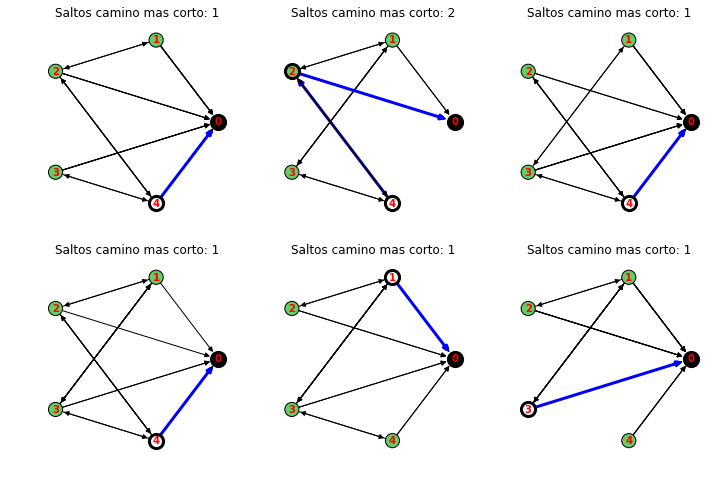

In [3]:
# En esta sección generamos grafos de manera aleatoria usando las funciones presentadas anteriormente. Exponemos algunos valores para controlar la generación de los mismos.

# Path al archivo que define el contact plan base a utilizar
path_contactplan = "scenarios/Walker-53x4x2x45-2day.txt"
#path_contactplan = "scenarios/Walker-53x16x4x22.txt"


# Longitud temporal de los sub contact plan a utilizar [seg]
t_window = 45000

# Cantidad de grafos a generar:
num_examples = 6

input_graphs, target_graphs, graphs = generate_networkx_graphs(rand, path_contactplan, t_window, num_examples)

# Para cada uno de los grafos generados, se utiliza la clase `GraphPlotter` para graficarlos (con la solución). 
num = min(num_examples, 16)
w = 3
h = int(np.ceil(num / w))
fig = plt.figure(40, figsize=(w * 4, h * 4))
fig.clf()

for j, graph in enumerate(graphs):
  ax = fig.add_subplot(h, w, j + 1)
  pos = nx.circular_layout(graph)
  plotter = GraphPlotter(ax, graph, pos)
  plotter.draw_graph_with_solution()

  # Labels
  for i in pos:
    ax.text(pos[i][0], pos[i][1], str(i), size=10, bbox=None, fontweight='bold',color='r', horizontalalignment="center", verticalalignment="center", zorder=110)


### Modelo

In [4]:
# El modelo para la búsqueda de camino más corto incluye:
# 1. Un *encoder* de graph_net, que codifica los arcos, nodos y sus atributos.
# 2. Un *core* de graph_net, que ejecuta N rondas de procesamiento (del tipo *message passing*). Toma como entrada la salida del *encoder*, pero tambien la salida del mismo *core* de la iteración anterior.
# 3. Un *decoder* de graph_net, que decodifica arcos, nodos y sus atributos. 

#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*

# El modelo se entrena con el mecanismo de *aprendizaje supervisado*.
# Los grafos de entrada (*input*) se generan aleatoreamente.

# La función de pérdida se computa en cada iteración.
# Y no hay necesidad de datasets de *entrenamiento* y *evaluación* separados, ya que las entradas no se repiten nunca.
# En este ejemplo se estudia hasta que punto los modelos se generalizan a grafos de el doble de tamaño en base a los cuales se entrenó el modelo.

tf.reset_default_graph()
rand = np.random.RandomState(seed=SEED)

# 1. Parámetros del modelo
# Pasos de procesamiento (message-passing).
num_processing_steps_tr = 5
num_processing_steps_ge = 5
num_processing_steps_predict = 5
# Parámetros de entrenamiento
num_training_iterations = 10000
path_contactplan = "scenarios/Walker-53x4x2x45-2day.txt"
#path_contactplan = "scenarios/Walker-53x16x4x22.txt"
t_window = 45000
batch_size_tr = 32
batch_size_ge = 100

# 2. Parámetros de datos
# Placeholders Input y target
input_ph, target_ph = create_placeholders(rand, path_contactplan, t_window, batch_size_tr)

# 3. Conexión datos y modelos
# Instanciación del modelo
model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
# Lista de salida (*oututs*), uno por cada paso de procesamiento
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)
output_ops_predict = model(input_ph, num_processing_steps_predict)
# Función pérdida (training y generalización)
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# 4. Optimización (adam)
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# 5. Reset (resetea la sesión de tensor flow, pero deja el mismo)
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)


saver = tf.train.Saver()

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()

use_backup=False
if use_backup:
  saver.restore(sess, 'GNN_model_toNode0-19999')
else:  
  sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
metrics_tr = []
losses_ge = []
metrics_ge = []


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Entrenamiento

In [5]:
# Tal como se usa en el ejemplo de la librería GNN, esta celda de entrenmiento puede interrurpirse en cualquier momento sin pérdida de los avances en la optimización del modelo. En efecto, el entrenamiento puede resumirse en cualquier momento, y el avance se puede visualizar en la celda siguiente.
log_every_seconds = 20

# La salida de esta celda ofrece la siguiente salida:
print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (generalization loss), "
      "F1-nodes-tr, F1-edges-tr, Accuracy-tr, F1-nodes-ge, F1-edges-ge, Accuracy-ge")
      #"Ctr (training fraction nodes/edges labeled correctly), "
      #"Str (training fraction examples solved correctly), "
      #"Cge (test/generalization fraction nodes/edges labeled correctly), "
      #"Sge (test/generalization fraction examples solved correctly)")
# 1. #: Número de iteración
# 2. T: Tiempo desde el inicio
# 3. Ltr: pérdida de entrenamiento (grafos chicos para entrenamiento)
# 4. Lge: pérdida de generalización (grafos grandes para generalización)
# 5. Ctr: fracción de nodos y arcos de entrenamiento etiquetados correctamente
# 6. Str: fracción de grafos de entrenamieto completos etiquetados correctamente
# 7. Ctr: fracción de nodos y arcos de generalización etiquetados correctamente
# 8. Str: fracción de grafos de generalización completos etiquetados correctamente

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  feed_dict, _ = create_feed_dict(rand, path_contactplan, t_window, batch_size_tr, input_ph, target_ph)
  train_values = sess.run({
      "step": step_op,
      "target": target_ph,
      "loss": loss_op_tr,
      "outputs": output_ops_tr}, feed_dict=feed_dict)
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    feed_dict, raw_graphs = create_feed_dict(rand, path_contactplan, t_window, batch_size_ge, input_ph, target_ph)
    test_values = sess.run({
        "target": target_ph,
        "loss": loss_op_ge,
        "outputs": output_ops_ge}, feed_dict=feed_dict)
    metric_tf = compute_accuracy(train_values["target"], train_values["outputs"][-1], use_nodes=True ,use_edges=True)
    metric_ge = compute_accuracy(test_values["target"], test_values["outputs"][-1], use_nodes=True , use_edges=True)
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    metrics_tr.append(metric_tf)
    losses_ge.append(test_values["loss"])
    metrics_ge.append(metric_ge)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, F1-nodes-tr {:.4f}, F1-edges-tr {:.4f}, Accuracy-tr"
          " {:.4f}, F1-nodes-ge {:.4f}, F1-edges-ge {:.4f}, Accuracy-ge {:.4f}".format(
            iteration, elapsed, train_values["loss"], test_values["loss"], metric_tf['f1_nodes'], metric_tf['f1_edges'], metric_tf['accuracy_graph'],
            metric_ge['f1_nodes'], metric_ge['f1_edges'], metric_ge['accuracy_graph']))

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (generalization loss), F1-nodes-tr, F1-edges-tr, Accuracy-tr, F1-nodes-ge, F1-edges-ge, Accuracy-ge
# 00149, T 21.1, Ltr 1.6568, Lge 1.6175, F1-nodes-tr 0.9479, F1-edges-tr 0.0000, Accuracy-tr 0.0000, F1-nodes-ge 0.9487, F1-edges-ge 0.0000, Accuracy-ge 0.0000
# 00331, T 40.3, Ltr 1.3772, Lge 1.2792, F1-nodes-tr 0.9479, F1-edges-tr 0.1511, Accuracy-tr 0.0938, F1-nodes-ge 0.9600, F1-edges-ge 0.0700, Accuracy-ge 0.0600
# 00522, T 60.4, Ltr 1.3794, Lge 1.0571, F1-nodes-tr 0.9723, F1-edges-tr 0.2344, Accuracy-tr 0.1250, F1-nodes-ge 0.9714, F1-edges-ge 0.2718, Accuracy-ge 0.1400
# 00711, T 80.4, Ltr 1.5510, Lge 1.4586, F1-nodes-tr 0.9244, F1-edges-tr 0.3386, Accuracy-tr 0.1250, F1-nodes-ge 0.9363, F1-edges-ge 0.3351, Accuracy-ge 0.2000
# 00900, T 100.5, Ltr 1.6112, Lge 1.3059, F1-nodes-tr 0.9744, F1-edges-tr 0.3491, Accuracy-tr 0.2500, F1-nodes-ge 0.9535, F1-edges-ge 0.3101, Accuracy-ge 0.1900
# 01091, T 120.6, Ltr 0.8876, L

In [6]:
saver.save(sess, 'GNN_model_toNode0', global_step=iteration)

'GNN_model_toNode0-9999'

### Resultados

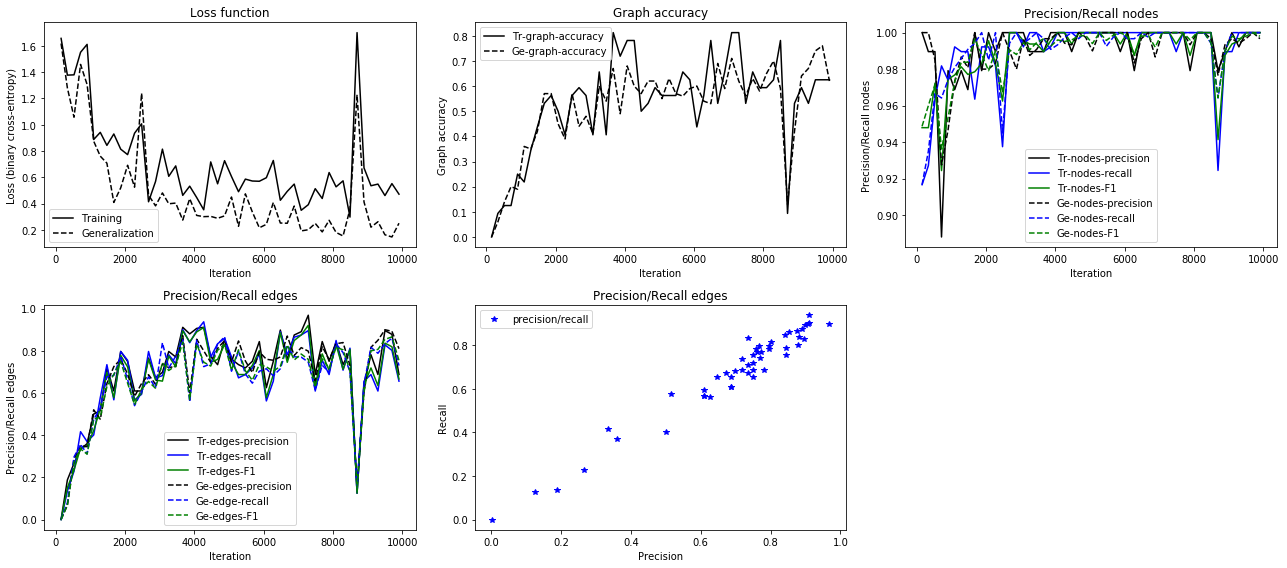

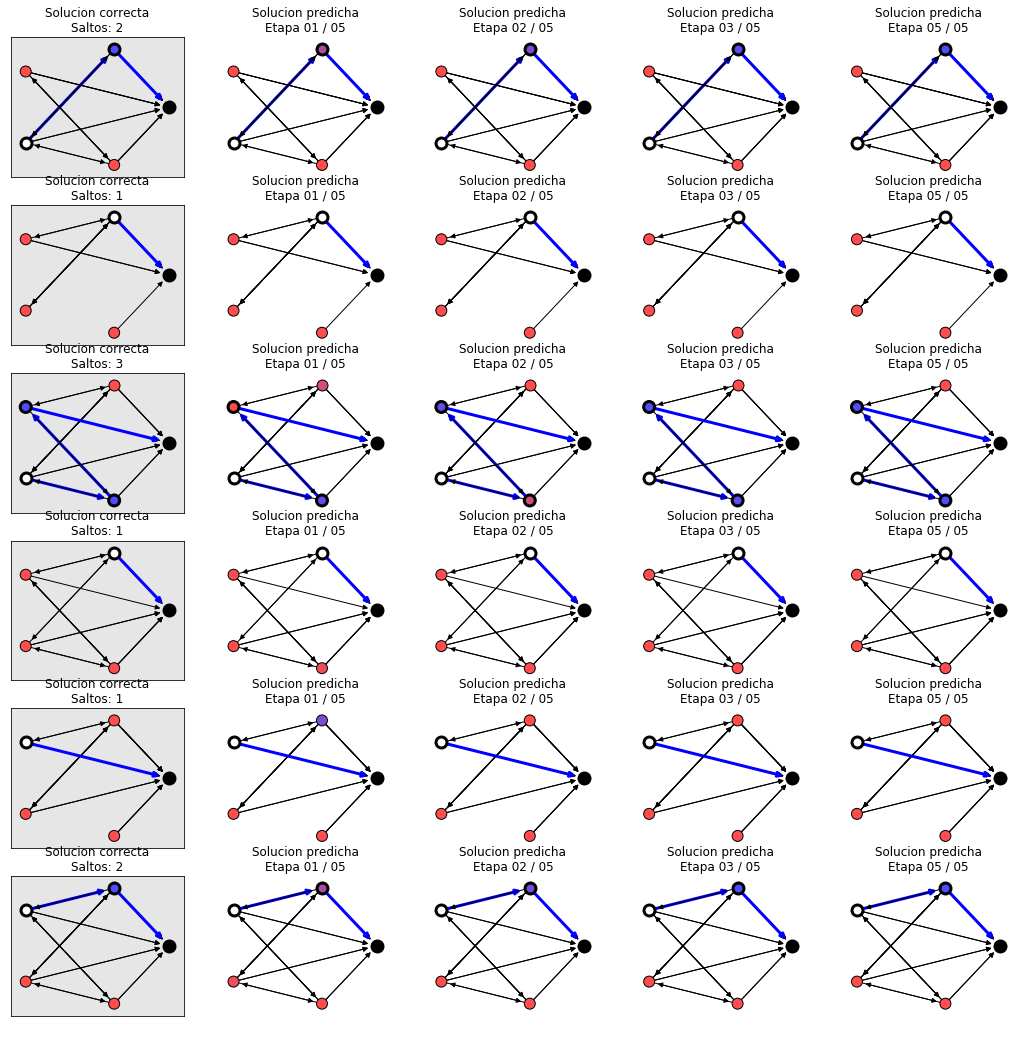

In [7]:
# Esta celda permite visualizar el resutado del entrenamiento de la celda anterior.

def softmax_prob_last_dim(x):  # pylint: disable=redefined-outer-name
  e = np.exp(x)
  return e[:, -1] / np.sum(e, axis=-1)

fig = plt.figure(1, figsize=(18, 8))
fig.clf()
x = np.array(logged_iterations)
# 1. Primero se imprimen las curvas de pérdida a lo largo del entrenamiento y de la generaización (test).
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(2, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Generalization")
ax.set_title("Loss function")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()

# 1. Luego imprime la fracción de predicciones correctas de grafos completos tanto en entrenamiento y generalización. 
y_tr = pd.DataFrame(metrics_tr)
y_ge = pd.DataFrame(metrics_ge)

ax = fig.add_subplot(2, 3, 2)
ax.plot(x, y_tr['accuracy_graph'], "k", label="Tr-graph-accuracy")
ax.plot(x, y_ge['accuracy_graph'], "k--", label="Ge-graph-accuracy")
ax.set_title("Graph accuracy")
ax.set_xlabel("Iteration")
ax.set_ylabel("Graph accuracy")
ax.legend()

# 3. Luego imprime precision/recall/f1 nodes
ax = fig.add_subplot(2, 3, 3)
ax.plot(x, y_tr['precision_nodes'], "k", label="Tr-nodes-precision")
ax.plot(x, y_tr['recall_nodes'], "b", label="Tr-nodes-recall")
ax.plot(x, y_tr['f1_nodes'], "g", label="Tr-nodes-F1")
ax.plot(x, y_ge['precision_nodes'], "k--", label="Ge-nodes-precision")
ax.plot(x, y_ge['recall_nodes'], "b--", label="Ge-nodes-recall")
ax.plot(x, y_ge['f1_nodes'], "g--", label="Ge-nodes-F1")
ax.set_title("Precision/Recall nodes")
ax.set_xlabel("Iteration")
ax.set_ylabel("Precision/Recall nodes")
ax.legend()

# 4. Luego imprime precision/recall/f1 edges
ax = fig.add_subplot(2, 3, 4)
ax.plot(x, y_tr['precision_edges'], "k", label="Tr-edges-precision")
ax.plot(x, y_tr['recall_edges'], "b", label="Tr-edges-recall")
ax.plot(x, y_tr['f1_edges'], "g", label="Tr-edges-F1")
ax.plot(x, y_ge['precision_edges'], "k--", label="Ge-edges-precision")
ax.plot(x, y_ge['recall_edges'], "b--", label="Ge-edge-recall")
ax.plot(x, y_ge['f1_edges'], "g--", label="Ge-edges-F1")
ax.set_title("Precision/Recall edges")
ax.set_xlabel("Iteration")
ax.set_ylabel("Precision/Recall edges")
ax.legend()

ax = fig.add_subplot(2, 3, 5)
ax.plot(y_tr['precision_edges'], y_tr['recall_edges'], "b*", label="precision/recall")
ax.set_title("Precision/Recall edges")
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.legend()

plt.tight_layout()



# Además de las curvas de rendimiento del entrenamiento, el ejemplo de la libraría recuerda las etiquetas de caminos más cortos a lo largo del proceso, en base a los cuales se puede imprimir y graficar la evolución de los caminos elegidos en cada grafo.
# En las gráficas de nodos, en nodo origen se imprime en blanco, el nodo destino en negro. El resto de los nodos queda en un gradiente rojo/azul que indica la certidumbre del modelo de que el nodo está fuera del camino más corto (rojo) o bien de que el mismo está dentro del camino más corto (azul).
max_graphs_to_plot = 6
num_steps_to_plot = 4
node_size = 120
min_c = 0.3
num_graphs = len(raw_graphs)
targets = utils_np.graphs_tuple_to_data_dicts(test_values["target"])
step_indices = np.floor(
    np.linspace(0, num_processing_steps_ge - 1,
                num_steps_to_plot)).astype(int).tolist()
outputs = list(
    zip(*(utils_np.graphs_tuple_to_data_dicts(test_values["outputs"][i])
          for i in step_indices)))
h = min(num_graphs, max_graphs_to_plot)
w = num_steps_to_plot + 1
fig = plt.figure(101, figsize=(18, h * 3))
fig.clf()
ncs = []
for j, (graph, target, output) in enumerate(zip(raw_graphs, targets, outputs)):
  if j >= h:
    break
  pos = nx.circular_layout(graph)
  ground_truth = target["nodes"][:, -1]
  # Ground truth.
  iax = j * (1 + num_steps_to_plot) + 1
  ax = fig.add_subplot(h, w, iax)
  plotter = GraphPlotter(ax, graph, pos)
  color = {}
  for i, n in enumerate(plotter.nodes):
    color[n] = np.array([1.0 - ground_truth[i], 0.0, ground_truth[i], 1.0
                        ]) * (1.0 - min_c) + min_c
  plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
  ax.set_axis_on()
  ax.set_xticks([])
  ax.set_yticks([])
  try:
    ax.set_facecolor([0.9] * 3 + [1.0])
  except AttributeError:
    ax.set_axis_bgcolor([0.9] * 3 + [1.0])
  ax.grid(None)
  ax.set_title("Solucion correcta\nSaltos: {}".format(
      plotter.solution_length))
  # Prediction.
  for k, outp in enumerate(output):
    iax = j * (1 + num_steps_to_plot) + 2 + k
    ax = fig.add_subplot(h, w, iax)
    plotter = GraphPlotter(ax, graph, pos)
    color = {}
    prob = softmax_prob_last_dim(outp["nodes"])
    for i, n in enumerate(plotter.nodes):
      color[n] = np.array([1.0 - prob[n], 0.0, prob[n], 1.0
                          ]) * (1.0 - min_c) + min_c
    plotter.draw_graph_with_solution(node_size=node_size, node_color=color)
    ax.set_title("Solucion predicha\nEtapa {:02d} / {:02d}".format(
        step_indices[k] + 1, step_indices[-1] + 1))

## Predicciones

In [21]:
def Get_Route_from_GNN(raw_graph, output_graph):
  # cargo las probabilidad en el grafo
  def softmax_prob_last_dim(x):
    e = np.exp(x)
    return e[:, -1] / np.sum(e, axis=-1)

  edges_probs = softmax_prob_last_dim(output_graph[0]['edges'])

  for i,prob in zip(raw_graph.edges, edges_probs):
    raw_graph.edges[i]['prob']=prob

  # Busco el nodo de inicio
  # Extraigo del grafo los nodos frm y to
  for i in raw_graph.nodes.data():
    if i[1]['frm']:
      node_frm = i[0]
    if i[1]['to']:
      node_to = i[0]
  
  print("Frm: " + str(node_frm) + " To: " + str(node_to) + " - at t_start: " + str(raw_graph.graph['t_inicial']))

  path_nodes = [node_frm]
  path_edges = []

  while path_nodes[-1] != node_to:
    max_prob=0
    next_node=None
    next_edge=None

    candidates = raw_graph.out_edges(path_nodes[-1], keys=True, data=True)
    if len(candidates)==0:
      raise ValueError("No se pudo encontrar una solucion")
    for i in candidates:
      if (i[3]['prob'] > max_prob) and not (i[1] in path_nodes):
        max_prob = i[3]['prob']
        next_node = i[1]
        next_edge = (i[0],i[1],i[2],round(i[3]['prob'],5))

    path_nodes.append(next_node)
    path_edges.append(next_edge)

  print("Path - Nodes: " + str(path_nodes))
  print("Path - Edges: " + str(path_edges))

In [22]:
hops_vs_accuracy = [[],[],[],[],[],[],[]]

In [26]:
# Genero un grafo de ejemplo
path_contactplan_eval  = "scenarios/Walker-53x4x2x45_Eval.txt"
#path_contactplan_eval = "scenarios/Walker-53x16x4x22_Eval.txt"
full_contactplan_eval  = load_contactplan(path_contactplan_eval)
for _ in range(10000):
    graph_eval, sub_contactplan_eval = generate_graph(rand, full_contactplan_eval, t_window, node_B=0)

    # Adapto el grafo a la red neuronal
    input_graph_eval    = graph_to_input(graph_eval)
    input_tuple_eval    = utils_np.networkxs_to_graphs_tuple([input_graph_eval])

    # paso el grafo por la red neuronal
    Predict_tuple_eval  = sess.run({"outputs": output_ops_predict}, feed_dict={input_ph: input_tuple_eval})
    Predict_dict_eval   = utils_np.graphs_tuple_to_data_dicts(Predict_tuple_eval['outputs'][num_processing_steps_predict-1])

    # Imprimo resultado de la prediccion
    print("Prediccion: ")
    Get_Route_from_GNN(graph_eval, Predict_dict_eval)


    # Add Ground truth
    graph_eval = add_cgr_path(rand, graph_eval, sub_contactplan_eval)

    # Print Ground truth
    t_inicial  = graph_eval.graph['t_inicial']
    path_nodes_gt = graph_eval.graph['path_nodes']
    path_edges_gt = graph_eval.graph['path_edges']
    print("GroundTruth: ")
    print("Frm: {} to {} - at t_start: {}".format(path_nodes_gt[0], path_nodes_gt[-1], t_inicial))
    print("Path - Nodes: " + str(path_nodes_gt))
    print("Path - Edges: " + str(path_edges_gt))

    # ACCURACY
    target_graph_eval = graph_to_target(graph_eval)
    target_tuple_eval = utils_np.networkxs_to_graphs_tuple([target_graph_eval])
    metric_eval = compute_accuracy(target_tuple_eval, Predict_tuple_eval['outputs'][num_processing_steps_predict-1], use_nodes=True ,use_edges=True)
    hops_vs_accuracy[int(len(target_graph_eval.graph['path_edges']))].append(metric_eval['accuracy_graph'])

Prediccion: 
Frm: 3 To: 0 - at t_start: 91259
Path - Nodes: [3, 1, 0]
Path - Edges: [(3, 1, 22755.0, 0.56261), (1, 0, 42927.0, 0.86489)]
GroundTruth: 
Frm: 3 to 0 - at t_start: 91259
Path - Nodes: [3, 1, 0]
Path - Edges: [(3, 1, 25631.0), (1, 0, 30452.0)]
Prediccion: 
Frm: 1 To: 0 - at t_start: 26112
Path - Nodes: [1, 0]
Path - Edges: [(1, 0, 12690.0, 0.99979)]
GroundTruth: 
Frm: 1 to 0 - at t_start: 26112
Path - Nodes: [1, 0]
Path - Edges: [(1, 0, 6811.0)]
Prediccion: 
Frm: 4 To: 0 - at t_start: 10419
Path - Nodes: [4, 2, 0]
Path - Edges: [(4, 2, 8453.0, 0.97206), (2, 0, 28893.0, 0.1179)]
GroundTruth: 
Frm: 4 to 0 - at t_start: 10419
Path - Nodes: [4, 2, 0]
Path - Edges: [(4, 2, 8453.0), (2, 0, 28893.0)]
Prediccion: 
Frm: 4 To: 0 - at t_start: 82488
Path - Nodes: [4, 0]
Path - Edges: [(4, 0, 2715.0, 0.99999)]
GroundTruth: 
Frm: 4 to 0 - at t_start: 82488
Path - Nodes: [4, 0]
Path - Edges: [(4, 0, 2715.0)]
Prediccion: 
Frm: 2 To: 0 - at t_start: 3179
Path - Nodes: [2, 0]
Path - Edges: 

In [24]:
hops_vs_accuracy
hops_vs_accuracy_np=np.array([np.array(xi) for xi in hops_vs_accuracy])
for i, data in enumerate(hops_vs_accuracy_np):
    print(str(i) + ": " + str(data.mean()))

0: nan
1: 0.8292
2: 0.7786654135338346
3: 0.6693548387096774
4: nan
5: nan
6: nan


/home/mati-d/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/home/mati-d/.local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
hops_vs_accuracy
hops_vs_accuracy_np=np.array([np.array(xi) for xi in hops_vs_accuracy])
for i, data in enumerate(hops_vs_accuracy_np):
    print(str(i) + ": " + str(data.mean()))

0: nan
1: 0.7081237002750386
2: 0.5594470046082949
3: 0.40239043824701193
4: nan
5: nan
6: nan


/home/mati-d/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


In [ ]:
# Lineas para testear cada una de las funciones
#rand = np.random.RandomState(seed=SEED)
#contact_plan = load_contactplan('Walker-53x4x2x45.txt')
#graph_from_cp, sub_contact_plan = generate_graph(rand, contact_plan, 40000)
#graph_with_cgr = add_cgr_path(rand, graph_from_cp, sub_contact_plan)
#input_graph, target_graph = graph_to_input_target(graph_with_cgr)
#input_graphs, target_graphs, graphs = generate_networkx_graphs(rand, 'Walker-53x4x2x45.txt', 40000, 5)
#input_ph, target_ph = create_placeholders(rand, 'Walker-53x4x2x45.txt', 40000, 5)
#feed_dict, raw_graphs = create_feed_dict(rand, 'Walker-53x4x2x45.txt', 40000, 5, input_ph, target_ph)

#target_graphs_tuple=utils_np.networkxs_to_graphs_tuple(target_graphs)
#correct, solved = compute_accuracy(target_graphs_tuple, target_graphs_tuple, use_edges=True, use_nodes=True)
#pdb.set_trace()

In [ ]:
# TODO List:
#  - Separar datasets, train and test, y balancearlos para que el numero de hops sea equitativo
#  - Metricas: Agregar accuracy vs numero de hops
#  - Graficar edges por separado

# Para mejorar:
#  - Normalizar tiempos entre 0 y 1
#  - toquetear parametros de entrenamiento
#  - agregar algun feature
#  - toquetear modelo 